In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import datetime
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA

import os, sys
base_dir = os.path.join("/home/jovyan/work/Corona/COVID-19")
sys.path.append(base_dir)
import model as md

In [3]:
merger = md.Merger(data_dir="data", load_from_raw=True, write_agg=True, load_from_agg=True)
merger = md.Merger(data_dir="data", load_from_raw=False, load_from_agg=True)

In [4]:
def add_prediction(data):
        # contrived dataset
        data_list = data.to_list()
        data_log_list = np.log(data_list)
        # fit model
        model = AutoReg(data_log_list, lags=1)
        model_fit = model.fit()
        # make prediction
        predict = model_fit.predict(0, len(data_list)+1)
        return np.exp(predict)

In [5]:
columns = ["additional.infected","additional.deaths","hospital","onVentilator","active.infected"]
columns = ["onVentilator","hospital","cumulated.vaccinated","cumulated.vaccins"]
selected_df = merger.df["details"][["date"] + columns].dropna()
rolling_mean = selected_df[selected_df["date"]>="2021-01-01"].set_index(["date"]).rolling(2).mean().dropna()
# Set back to rolling(7) after more than 7 data points (2021-01-12)
rolling_mean = rolling_mean.assign(
    additional_vaccinated=rolling_mean["cumulated.vaccinated"]-rolling_mean["cumulated.vaccinated"].shift(1),
    additional_vaccins=rolling_mean["cumulated.vaccins"]-rolling_mean["cumulated.vaccins"].shift(1))
rolling_mean

,onVentilator,hospital,cumulated.vaccinated,cumulated.vaccins,additional_vaccinated,additional_vaccins
date,,,,,,
2021-01-13,347.5,4937.5,82754.0,104071.5,NaN,NaN
2021-01-14,341.5,4779.5,91515.0,129712.0,8761.0,25640.5
2021-01-15,340.5,4644.5,100914.5,129860.0,9399.5,148.0
2021-01-16,332.5,4504.0,109287.5,129860.0,8373.0,0.0
2021-01-17,328.5,4376.5,116395.5,129860.0,7108.0,0.0
2021-01-18,329.5,4395.0,121566.0,129860.0,5170.5,0.0
2021-01-19,319.5,4445.0,126438.5,129860.0,4872.5,0.0
2021-01-20,301.5,4331.5,130003.5,147702.5,3565.0,17842.5
2021-01-21,290.0,4133.5,132436.0,165545.0,2432.5,17842.5


In [6]:
new_row = pd.DataFrame(
    [[max(rolling_mean.reset_index()["date"]) + datetime.timedelta(days=1)] + [None] * len(columns)], 
    columns=["date"] + columns
).set_index("date")
rolling_mean_pred = rolling_mean.append(new_row)
rolling_mean_pred.tail(5)

for key in columns:
    rolling_mean_pred["pred_{}".format(key)] = add_prediction(rolling_mean[key])
    rolling_mean_pred["error_{}".format(key)] = rolling_mean_pred[key]-rolling_mean_pred["pred_{}".format(key)]

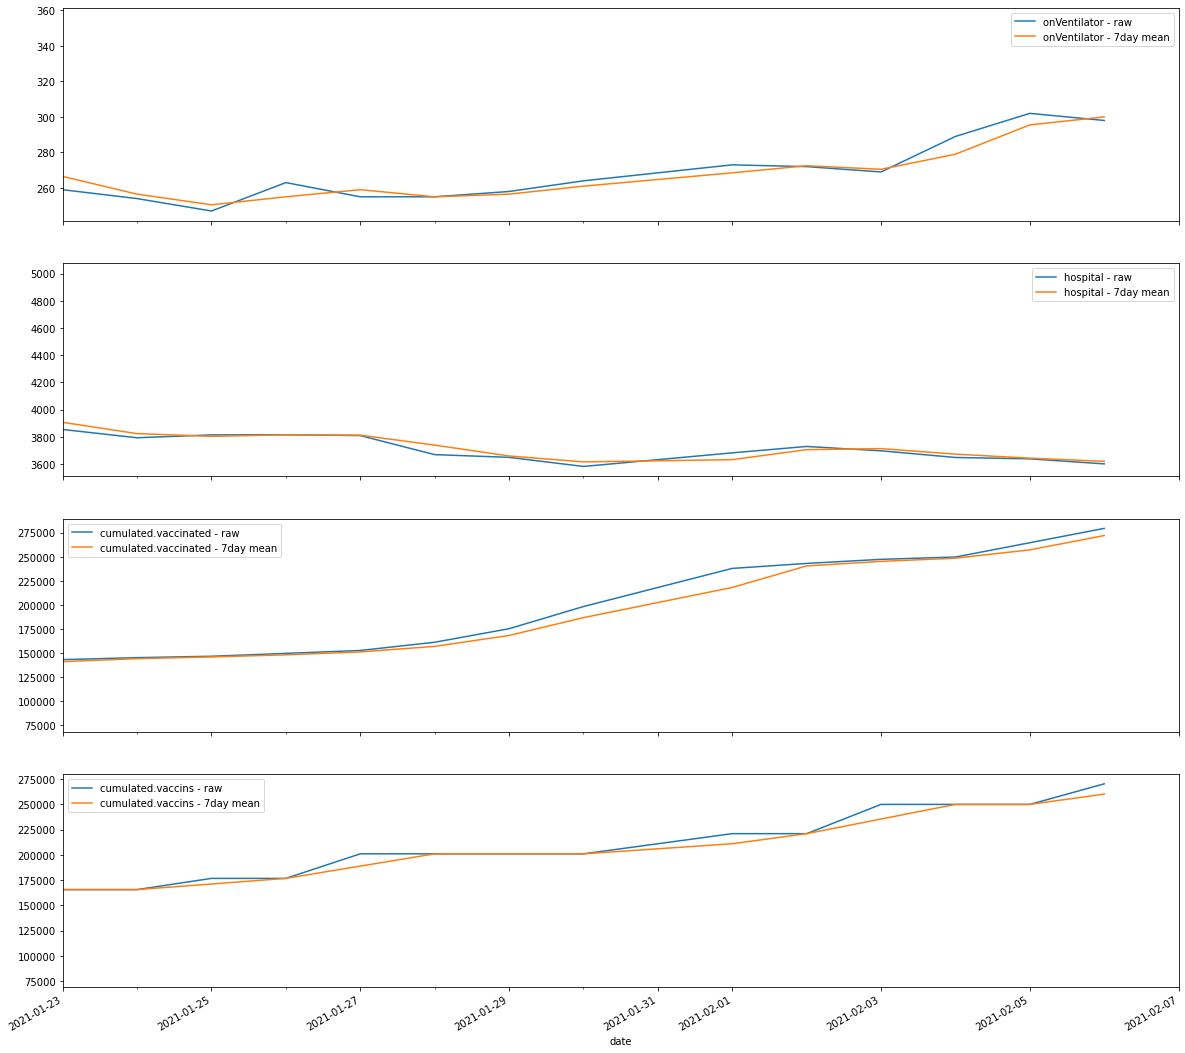

,onVentilator,hospital,cumulated.vaccinated,cumulated.vaccins,additional_vaccinated,additional_vaccins,pred_onVentilator,error_onVentilator,pred_hospital,error_hospital,pred_cumulated.vaccinated,error_cumulated.vaccinated,pred_cumulated.vaccins,error_cumulated.vaccins
date,,,,,,,,,,,,,,
2021-02-05,295.5,3643.0,257108.5,250000.0,8630.0,0.0,292.864821,2.635179,3628.091074,14.908926,268290.459724,-11181.959724,254352.089796,-4352.089796
2021-02-06,300.0,3619.5,271970.0,260200.0,14861.5,10200.0,296.895875,3.104125,3606.870203,12.629797,283530.991367,-11560.991367,264119.160440,-3919.160440
2021-02-07,NaN,NaN,NaN,NaN,NaN,NaN,294.115855,NaN,3595.459977,NaN,295377.140078,NaN,267866.052873,NaN


In [7]:
(fig, ax) = plt.subplots(figsize=(20,5*len(columns)), nrows=len(columns), sharex=True)
for key in columns:
    index = columns.index(key)
    ax[index].set_xlim(
        datetime.date.today() - datetime.timedelta(days=14),
        datetime.date.today() + datetime.timedelta(days=1)
    )
    #ax[index].set_yscale("log")
    selected_df.plot(x="date", y=key, ax=ax[index], label="{} - raw".format(key))
    rolling_mean.reset_index().plot(x="date", y=key, ax=ax[index], label="{} - 7day mean".format(key))
    #rolling_mean_pred.reset_index().plot(x="date", y="pred_{}".format(key), ax=ax[index], label="{} - pred".format(key))
plt.legend()
plt.show()
rolling_mean_pred.tail(3)

In [8]:
rolling_mean_pred.tail(5)

,onVentilator,hospital,cumulated.vaccinated,cumulated.vaccins,additional_vaccinated,additional_vaccins,pred_onVentilator,error_onVentilator,pred_hospital,error_hospital,pred_cumulated.vaccinated,error_cumulated.vaccinated,pred_cumulated.vaccins,error_cumulated.vaccins
date,,,,,,,,,,,,,,
2021-02-03,270.5,3713.0,245153.0,235500.0,4699.0,14500.0,270.360413,0.139587,3691.226667,21.773333,256019.351849,-10866.351849,240427.622867,-4927.622867
2021-02-04,279.0,3672.5,248478.5,250000.0,3325.5,14500.0,278.033331,0.966669,3654.711929,17.788071,259433.627381,-10955.127381,254352.089796,-4352.089796
2021-02-05,295.5,3643.0,257108.5,250000.0,8630.0,0.0,292.864821,2.635179,3628.091074,14.908926,268290.459724,-11181.959724,254352.089796,-4352.089796
2021-02-06,300.0,3619.5,271970.0,260200.0,14861.5,10200.0,296.895875,3.104125,3606.870203,12.629797,283530.991367,-11560.991367,264119.160440,-3919.160440
2021-02-07,NaN,NaN,NaN,NaN,NaN,NaN,294.115855,NaN,3595.459977,NaN,295377.140078,NaN,267866.052873,NaN


https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

# Autoregression (AR)

In [20]:
# AR example
from statsmodels.tsa.ar_model import AutoReg
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = AutoReg(data, lags=1)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[100.95357141]


# Moving Average (MA)

In [18]:
# MA example
from statsmodels.tsa.arima_model import ARMA
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = ARMA(data, order=(0, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[72.85861191]


# Autoregressive Moving Average (ARMA)

In [20]:
# ARMA example
from statsmodels.tsa.arima_model import ARMA
from random import random
# contrived dataset
data = [random() for x in range(1, 100)]
# fit model
model = ARMA(data, order=(2, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[0.51375467]


# Autoregressive Integrated Moving Average (ARIMA)

In [21]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = ARIMA(data, order=(1, 1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data), typ='levels')
print(yhat)

[100.44781807]


# Seasonal Autoregressive Integrated Moving-Average (SARIMA)

In [24]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(2, 2, 2, 2)) # original: seasonal_order=(1, 1, 1, 1)
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


[100.53211767]


# Vector Autoregression (VAR)

In [25]:
# VAR example
from statsmodels.tsa.vector_ar.var_model import VAR
from random import random
# contrived dataset with dependency
data = list()
for i in range(100):
    v1 = i + random()
    v2 = v1 + random()
    row = [v1, v2]
    data.append(row)
# fit model
model = VAR(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.forecast(model_fit.y, steps=1)
print(yhat)

[[100.97799737 101.43105815]]


/opt/conda/lib/python3.7/site-packages/statsmodels/base/wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


# Vector Autoregression Moving-Average (VARMA)

In [26]:
# VARMA example
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random
# contrived dataset with dependency
data = list()
for i in range(100):
    v1 = random()
    v2 = v1 + random()
    row = [v1, v2]
    data.append(row)
# fit model
model = VARMAX(data, order=(1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.forecast()
print(yhat)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


[[0.5927996  0.98300934]]


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


# Vector Autoregression Moving-Average with Exogenous Regressors (VARMAX)

In [27]:
# VARMAX example
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random
# contrived dataset with dependency
data = list()
for i in range(100):
    v1 = random()
    v2 = v1 + random()
    row = [v1, v2]
    data.append(row)
data_exog = [x + random() for x in range(100)]
# fit model
model = VARMAX(data, exog=data_exog, order=(1, 1))
model_fit = model.fit(disp=False)
# make prediction
data_exog2 = [[100]]
yhat = model_fit.forecast(exog=data_exog2)
print(yhat)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


[[0.55357749 0.98259305]]


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


# Simple Exponential Smoothing (SES)

In [28]:
# SES example
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = SimpleExpSmoothing(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[99.4442112]


# Holt Winter’s Exponential Smoothing (HWES)

In [29]:
# HWES example
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = ExponentialSmoothing(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[99.00847223]
